In [1]:
import os
import pickle
import time
import numpy as np
import json
import matplotlib.pyplot as plt

# utils imports
from power_planner.data_reader import DataReader
from power_planner import graphs
from power_planner.plotting import plot_path_costs, plot_pipeline_paths, plot_path, plot_k_sp, plot_pareto
from power_planner.utils import get_distance_surface, time_test_csv
from config import Config

#### General configurations

In [2]:
PATH_FILES = "/Users/ninawiedemann/Downloads/tifs_new"

# DEFINE CONFIGURATION
ID = "w_ksp_5"  # str(round(time.time() / 60))[-5:]

OUT_PATH = "outputs/path_" + ID
SCALE_PARAM = 5  # args.scale
# normal graph pipeline
# PIPELINE = [(2, 50), (1, 0)]  # [(1, 0)]  # [(4, 80), (2, 50), (1, 0)]  #
# random graph pipeline
PIPELINE = [(1, 0)]  # [(0.9, 40), (0, 0)]

GRAPH_TYPE = graphs.WeightedKSP
# LineGraph, WeightedGraph, RandomWeightedGraph, RandomLineGraph, PowerBF
# TwoPowerBF, WeightedKSP
print("graph type:", GRAPH_TYPE)
# summarize: mean/max/min, remove: all/surrounding, sample: simple/watershed
NOTES = "None"  # "mean-all-simple"

IOPATH = os.path.join(PATH_FILES, "data_dump_" + str(SCALE_PARAM) + ".dat")

cfg = Config(SCALE_PARAM)

graph type: <class 'power_planner.graphs.weighted_ksp.WeightedKSP'>
defined pylon distances in raster: 3.0 5.0


## Load data

In [3]:
# READ DATA
with open(IOPATH, "rb") as infile:
    data = pickle.load(infile)
    (instance, instance_corr, start_inds, dest_inds) = data.data

In [4]:
graph = GRAPH_TYPE(
    instance, instance_corr, graphtool=cfg.GTNX, verbose=cfg.VERBOSE
)

graph.set_edge_costs(
    data.layer_classes, data.class_weights, angle_weight=cfg.ANGLE_WEIGHT
)
graph.set_shift(
    cfg.PYLON_DIST_MIN,
    cfg.PYLON_DIST_MAX,
    dest_inds - start_inds,
    cfg.MAX_ANGLE,
    max_angle_lg=cfg.MAX_ANGLE_LG
)
# add vertices
graph.add_nodes()

# START PIPELINE
tic = time.time()
corridor = np.ones(instance_corr.shape) * 0.5  # start with all
output_paths = []
plot_surfaces = []
time_infos = []

for (factor, dist) in PIPELINE:
    print("----------- PIPELINE", factor, dist, "---------------")
    graph.set_corridor(factor, corridor, start_inds, dest_inds)
    print("1) set cost rest")
    graph.add_edges()
    print("2) added edges", graph.n_edges)
    print("number of vertices:", graph.n_nodes)

    # weighted sum of all costs
    graph.sum_costs()
    source_v, target_v = graph.add_start_and_dest(start_inds, dest_inds)
    print("3) summed cost, get source and dest")
    # get actual best path
    path, path_costs, cost_sum = graph.get_shortest_path(source_v, target_v)
    print("4) shortest path")
    # save for inspection
    output_paths.append((path, path_costs))
    plot_surfaces.append(graph.cost_rest[2].copy())  # TODO: mean makes black
    # get several paths --> here: pareto paths
    paths = [path]
    # graph.get_pareto(
    #     np.arange(0, 1.1, 0.1), source_v, target_v, compare=[2, 3]
    # )

    time_infos.append(graph.time_logs.copy())

    if cfg.VERBOSE:
        del graph.time_logs['edge_list_times']
        del graph.time_logs['add_edges_times']
        print(graph.time_logs)

    if dist > 0:
        # PRINT AND SAVE timing test
        time_test_csv(
            ID, cfg.CSV_TIMES, SCALE_PARAM, cfg.GTNX, GRAPH_TYPE, graph,
            path_costs, cost_sum, dist, 0, NOTES
        )
        # do specified numer of dilations
        corridor = get_distance_surface(
            graph.pos2node.shape, paths, mode="dilation", n_dilate=dist
        )
        print("5) compute distance surface")
        # remove the edges of vertices in the corridor (to overwrite)
        graph.remove_vertices(corridor, delete_padding=cfg.PYLON_DIST_MAX)
        print("6) remove edges")

initialized weighted graph pos2node
['cultural', 'human', 'planning', 'technical'] [0.28571429 0.35714286 0.14285714 0.21428571]
Added nodes: 37960 in time: 0.017303943634033203
----------- PIPELINE 1 0 ---------------
1) set cost rest
n_neighbors: 28
Done adding edges: 483010
DONE adding 483010 edges: 0.7023649215698242
2) added edges 483010
number of vertices: 37960
3) summed cost, get source and dest
4) shortest path
{'init_graph': 0.0, 'add_nodes': 0.018, 'downsample': 0.0, 'set_cost_rest': 0.005, 'add_edges': 0.006, 'edge_list': 0.004, 'add_all_edges': 0.514, 'sum_of_costs': 0.014, 'shortest_path': 0.152}


out costs shape: (50, 4)


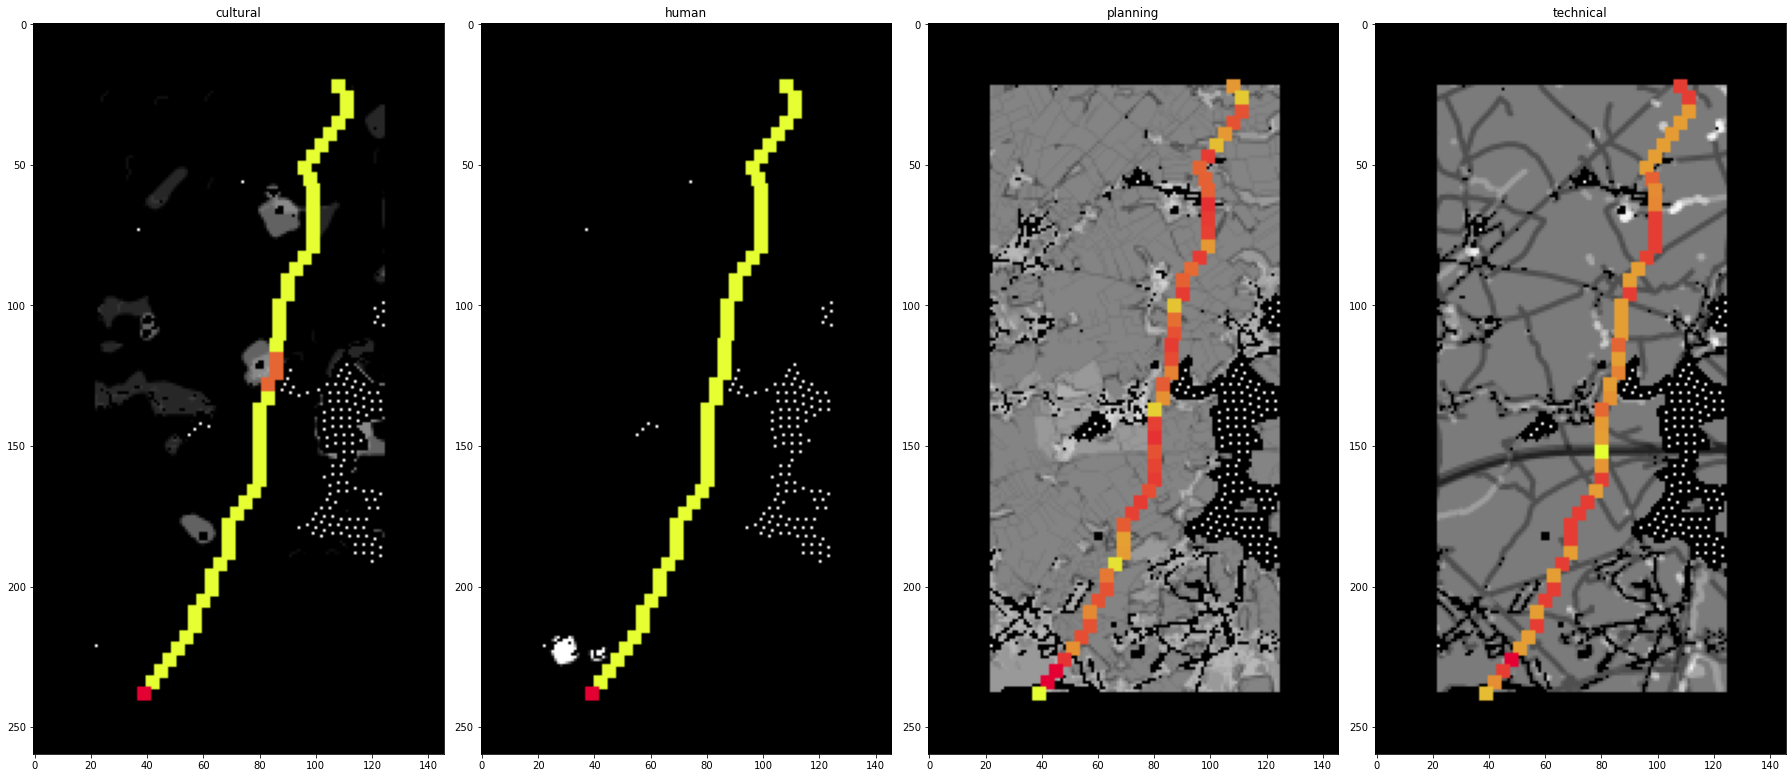

In [5]:
plot_path_costs(
    instance * instance_corr,
    path,
    path_costs,
    data.layer_classes,
    buffer=2
)

## Improve pareto computation

#### Notes:

We say that an alternative A dominates B if A outscores B regardless of the tradeoff between value and cost — that is, if A is both better and cheaper than B

In [6]:
import seaborn as sns
sns.set(style="ticks")

def plot_pareto_scatter_matrix(pareto, weights, classes):
    df = pd.DataFrame(pareto)
    sns.pairplot(df)

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd

def plot_pareto_3d(pareto, weights, classes):
    """
    3D plot of pareto points from 3 cost classes
    Arguments:
        pareto: np array of shape num_paths x 3, with costs for each path
        weights: array or list of shape num_paths x 3, giving the weights that yielded the pareto costs
        classes: list of 3 strings, the compared graphs
    """
    fig = plt.figure(figsize=(10,5))
    ax = Axes3D(fig)
    
    for i in range(len(pareto)):
        x, y, z = tuple(pareto[i])
        col_weights = (np.asarray([weights[i]])+0.4)/1.4
        # print(x,y,z, weights[i])
        ax.scatter(x, y, z, marker='o', s=100, c=col_weights, label=weights[i])

    ax.set_xlabel(classes[0], fontsize=15)
    ax.set_ylabel(classes[1], fontsize=15)
    ax.set_zlabel(classes[2], fontsize=15)
    # manually define legend
    legend_elements = [Line2D([0], [0],marker='o', color=[1,0,0], markersize=10, lw=0.1, label='only '+classes[0]),
                       Line2D([0], [0], marker='o', color=[0,1,0],lw=0.1, label='only '+classes[1], markersize=10),
                       Line2D([0], [0], marker='o', color=[0,0,1],lw=0.1, label='only '+classes[2], markersize=10)]

    # Create the figure
    ax.legend(handles=legend_elements, loc='upper center', fontsize=17)
    
    plt.show()

In [64]:
from matplotlib.lines import Line2D

def plot_pareto_scatter_3d(pareto, weights, classes):
    """
    3D plot of pareto points from 3 cost classes
    Arguments:
        pareto: np array of shape num_paths x 3, with costs for each path
        weights: array or list of shape num_paths x 3, giving the weights that yielded the pareto costs
        classes: list of 3 strings, the compared graphs
    """
    fig = plt.figure(figsize=(20,5))
    for i in range(3):
        ax = fig.add_subplot(1,3,i+1)
        ind1 = i
        ind2 = (i+1)%3
        for j in range(len(pareto)):
            label=np.argmax(weights[j])
            col_weights = (np.asarray([weights[j]])+0.4)/1.4
            ax.scatter(pareto[j,ind1], pareto[j,ind2], c=col_weights, label=label)
        plt.xlabel(classes[ind1], fontsize=17)
        plt.ylabel(classes[ind2], fontsize=17)
    legend_elements = [Line2D([0], [0],marker='o', color=[1,0,0], markersize=10, lw=0.1, label='only '+classes[0]),
                   Line2D([0], [0], marker='o', color=[0,1,0],lw=0.1, label='only '+classes[1], markersize=10),
                     Line2D([0], [0], marker='o', color=[0,0,1],lw=0.1, label='only '+classes[2], markersize=10)]

    # Create the figure
    ax.legend(handles=legend_elements, loc='upper center', fontsize=17)
    plt.savefig("pareto3d.pdf")
    plt.show()
    
def plot_pareto_scatter_2d(pareto, weights, classes):
    """
    Scatter to compare two cost classes
    Arguments:
        pareto: np array of shape num_paths x 2, with costs for each path
        weights: array or list of shape num_paths x 2, giving the weights that yielded the pareto costs
        classes: list of 2 strings, the compared graphs
    """
    color = np.array([[w[0], 0, w[1]] for w in weights])
    # scatter pareto curve
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.scatter(pareto[:,0], pareto[:,1], c=color)
    plt.xlabel(classes[0], fontsize=15)
    plt.ylabel(classes[1], fontsize=15)
    # manually create legend
    legend_elements = [Line2D([0], [0],marker='o', color=[1,0,0], markersize=10, lw=0.1, label='only '+classes[0]),
                   Line2D([0], [0], marker='o', color=[0,0,1],lw=0.1, label='only '+classes[1], markersize=10)]
    # Create the figure
    plt.legend(handles=legend_elements, loc='upper center', fontsize=17)
    plt.title("Pareto frontier for " + classes[0] + " vs " + classes[1])
    plt.show()

In [65]:
def get_pareto(self, vary, source, dest, out_path=None, non_compare_weight=0, compare=[0, 1]):
    """
    Arguments:
        vary: how many weights to explore, e.g 3 --> each cost class can have weight 0, 0.5 or 1
        source, dest: as always the source and destination vertex
        out_path: where to save the pareto figure(s)
        compare: indices of cost classes to compare
    Returns:
        paths: All found paths
        pareto: The costs for each combination of weights
    """
    # initialize lists
    pareto = list()
    paths = list()
    cost_sum = list()
    # 
    cost_arrs = [cost.get_array() for cost in self.cost_props]
    # [self.cost_props[comp].get_array() for comp in compare]
    var_weights = np.around(np.linspace(0,1, vary),2)
    
    if len(compare)==2:
        weights = [[v, 1-v] for v in var_weights]
    elif len(compare)==3:
        weights = list()
        for w0 in var_weights:
            for w1 in var_weights[var_weights<=1-w0]:
                weights.append([w0, w1, 1-w0-w1])
    else:
        raise ValueError("argument compare can only have length 2 or 3")
        
    for j in range(len(weights)):
        w = np.zeros(len(cost_arrs)) + non_compare_weight
        w[compare] = weights[j]
            
        self.weight.a = np.sum([cost_arrs[i] * w[i] for i in range(len(cost_arrs))], axis=0)
        # get shortest path
        path, path_costs, c_sum = self.get_shortest_path(source, dest)
        pareto.append(np.sum(path_costs, axis=0)[compare])
        paths.append(path)
        cost_sum.append(c_sum)
            
    pareto = np.array(pareto)
    classes = [self.cost_classes[comp] for comp in compare]
    # Plotting
    if len(compare)==2:
        plot_pareto_scatter_2d(pareto, weights, classes)
    elif len(compare)==3:
        # plot_pareto_3d(pareto, weights, classes)
        plot_pareto_scatter_3d(pareto, weights, classes)
    # TODO: return weights as well
    return paths, weights, cost_sum

In [16]:
%matplotlib notebook

In [ ]:
pareto_out = get_pareto(
    graph, 10, source_v, target_v, compare=[2, 3], non_compare_weight=0.5, out_path=1
)

In [74]:
def plot_pareto_paths(pareto_out, inst, out_path=None):
    """
    Plot k shortest paths on the instance
    Arguments:
        pareto_out: tuple of pareto outputs: (paths, weights, cost sums)
        inst: instance to plot on
    """
    # get relevant information
    paths, weight_colours, cost_sum = pareto_out 

    # plot main image (cost surface)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.swapaxes(inst, 1, 0))
    # iterate over k shortest paths
    for i, path in enumerate(paths):
        path = np.asarray(path)
        col = weight_colours[i]
        if len(col)==2:
            col = [col[0],0,col[1]]
        plt.plot(
            path[:, 0], path[:, 1], label=str(round(cost_sum[i], 2)), c= col, linewidth=3
        )
    # plot and save
    leg = plt.legend(fontsize=15)
    leg.set_title('Weighted costs', prop={'size': 15})
    plt.axis("off")
    if out_path is not None:
        plt.savefig(out_path + "_pareto_paths.pdf")
    else:
        plt.show()

In [ ]:
plot_pareto_paths(pareto_out, graph.instance)

## Plotting

<IPython.core.display.Javascript object>


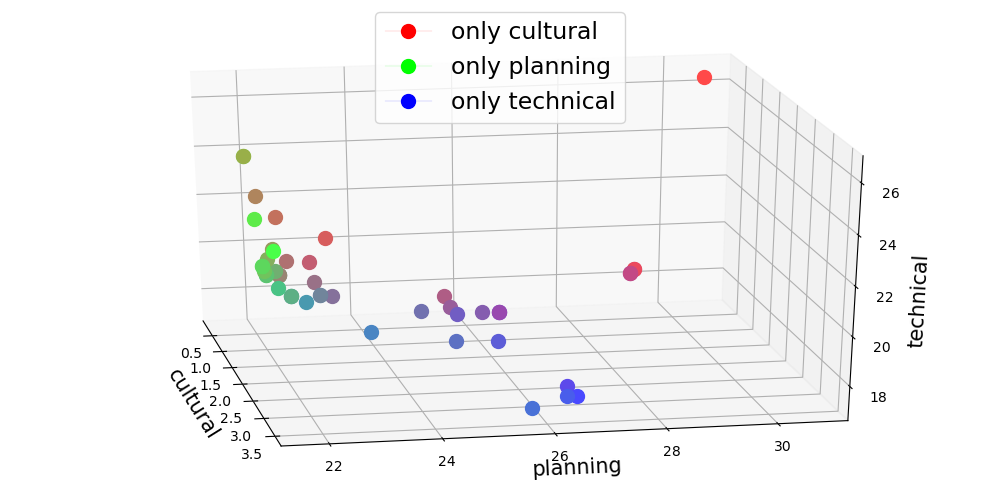

In [24]:
pareto_paths = get_pareto_3d(
    graph, 3, source_v, target_v, compare=[0, 2, 3], non_compare_weight=0.5, out_path=1
)

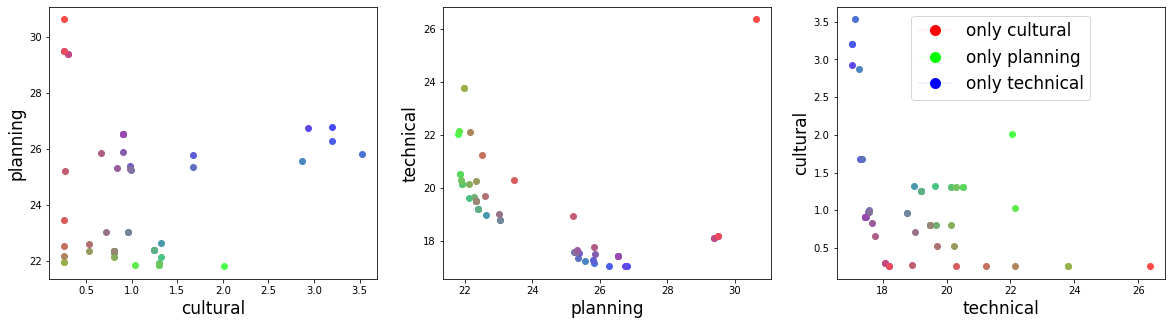

In [11]:
paths = get_pareto(
    graph, 10, source_v, target_v, compare=[0, 2, 3], out_path=1
)

### Interpretaion: 
* possible to optimize for cultural and technical costs simultanously
* if planning and cultural minimized, then technical tends to be high